In [117]:
import xgboost as xgb
import pandas as pd
import numpy as np

In [121]:
df_train = pd.read_csv('data/data_processed_train.csv')
df_test = pd.read_csv('data/data_processed_test.csv')
df = pd.concat((df_train, df_test), ignore_index=True)

string_cols = ['survey_language', 'disability']
df[string_cols] = df[string_cols].astype('category')
df[string_cols] = df[string_cols].apply(lambda x: x.cat.codes)

In [125]:
df

,id,person_id,trip_n,travel_date,travel_date_dow,o_purpose_category,d_purpose_category,num_non_hh_travelers,num_hh_travelers,num_travelers,...,income_aggregate,num_people,num_adults,num_kids,num_workers,num_students,disability,trip_distance,mode,trip_distance_category
0,0,0,0,30/05/2019,4,7,2,0,1,1,...,4,5,3,2,1,2,4,13.4,subway,long
1,1,0,1,01/06/2019,6,6,1,0,1,1,...,4,5,3,2,1,2,4,3.7,drive,long
2,2,0,2,02/06/2019,7,7,7,1,2,3,...,4,5,3,2,1,2,4,9.8,drive,long
3,3,0,3,02/06/2019,7,7,7,1,2,3,...,4,5,3,2,1,2,4,11.1,drive,long
4,4,0,4,03/06/2019,1,7,7,0,1,1,...,4,5,3,2,1,2,4,2.5,drive,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65733,65787,2991,48,27/06/2019,4,8,8,2,2,4,...,2,2,2,0,2,0,4,NaN,NaN,NaN
65734,65788,2991,49,27/06/2019,4,8,8,2,2,4,...,2,2,2,0,2,0,4,NaN,NaN,NaN
65735,65789,2991,50,27/06/2019,4,8,8,2,2,4,...,2,2,2,0,2,0,4,NaN,NaN,NaN
65736,65790,2991,51,27/06/2019,4,8,8,2,2,4,...,2,2,2,0,2,0,4,NaN,NaN,NaN


In [127]:
candidate_cols = [
#      'travel_date_dow',
#      'o_purpose_category',
     'd_purpose_category',
     'num_non_hh_travelers',
#      'num_hh_travelers',
     'num_travelers',
#      'o_location_type',
#      'd_location_type',
     'o_congestion',
     'd_congestion',
#      'age',
#      'employment',
#      'student',
#      'license',
#      'planning_apps',
#      'industry',
#      'gender',
#      'education',
#      'survey_language',
#      'num_bicycles',
     'num_vehicles',
     'res_type',
#      'rent_own',
#      'income_aggregate',
#      'num_people',
#      'num_adults',
#      'num_kids',
#      'num_workers',
#      'num_students',
#      'disability'
#     'trip_distance'
]

categorial_columns = ['travel_date_dow', 'o_purpose_category', 'd_purpose_category', 'o_location_type',
                      'd_location_type', 'age', 'employment', 'license', 'planning_apps', 'industry',
                      'gender', 'survey_language', 'res_type', 'rent_own',  'disability']

onehot = pd.get_dummies(df[candidate_cols], columns=[x for x in categorial_columns if x in candidate_cols])

X_train_val = onehot.to_numpy()[:len(df_train)]
group_train_val = df['person_id'].to_numpy()[:len(df_train)]
y_train_val = df['trip_distance'][:len(df_train)]

X_test = onehot.to_numpy()[len(df_train):]


In [128]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def mse_mae_mape(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    return mse, mae, mape



def k_fold_cross_validation_regression(X, y, group, model, fold=5):

    k_fold = GroupKFold(n_splits=5)

    train_metrics  = [] #[(mse, mae, mape) for each fold]
    val_metrics = []  
    

    for train_idx, validate_idx in k_fold.split(X, y, groups=group):
        X_train, X_val = X[train_idx], X[validate_idx]
        y_train, y_val = y[train_idx], y[validate_idx]
        
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        train_metrics.append(mse_mae_mape(y_train, y_train_pred))
        val_metrics.append(mse_mae_mape(y_val, y_val_pred))
    
    return train_metrics, val_metrics

In [129]:
model = xgb.XGBRegressor(objective='reg:squarederror',
                          n_estimators = 100,
                          n_jobs=-1,
                          random_state=42,
                          use_label_encoder =False)

train_metrics, val_metrics = k_fold_cross_validation_regression(X_train_val, y_train_val, group_train_val, model)


In [130]:
metrics = np.concatenate((train_metrics, val_metrics), axis=1)
metrics = metrics[:,[0, 3, 1, 4, 2, 5]]
train_metrics_df = pd.DataFrame(metrics, columns=['mse-train', 'mse-val', 'mae-train', 'mae-val', 'mape-train', 'mape-val'])
train_metrics_df

,mse-train,mse-val,mae-train,mae-val,mape-train,mape-val
0,9.982608,12.786300,2.122917,2.390696,3.714683,3.795468
1,10.485335,11.040669,2.183081,2.329133,3.749599,4.501996
2,10.141902,12.424529,2.146763,2.379385,3.714197,4.210707
3,10.265389,11.853643,2.154034,2.315271,3.729361,3.886081
4,10.304446,11.525895,2.170260,2.349204,3.782706,4.206388


In [131]:
## train model on whole dataset
model.fit(X_train_val, y_train_val)

# calculate training metrics
y_train_val_pred = model.predict(X_train_val)
print(mse_mae_mape(y_train_val, y_train_val_pred))

(10.390967110930017, 2.177247077640327, 3.784024893877415)


## Read test data


In [132]:
y_train_val_pred = model.predict(X_train_val)
y_test_pred = model.predict(X_test)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

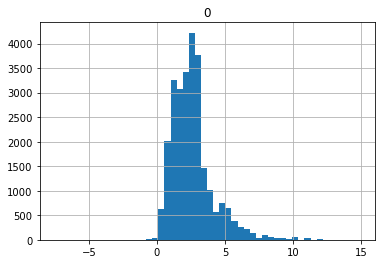

In [133]:
pd.DataFrame(y_test_pred).hist(bins=50)

In [134]:
# Append prediction to dataset
df_train['trip_distance'] = y_train_val_pred
df_test['trip_distance'] = y_test_pred

,Unnamed: 0,id,person_id,trip_n,travel_date,travel_date_dow,o_purpose_category,d_purpose_category,num_non_hh_travelers,num_hh_travelers,...,res_type,rent_own,income_aggregate,num_people,num_adults,num_kids,num_workers,num_students,disability,trip_distance
0,0,39498,1795,0,07/06/2019,5,1,6,0,1,...,6,2,1,2,2,0,1,1,none,1.060259
1,1,39499,1795,1,07/06/2019,5,6,6,0,1,...,6,2,1,2,2,0,1,1,none,1.060259
2,2,39500,1795,2,07/06/2019,5,6,1,0,1,...,6,2,1,2,2,0,1,1,none,1.635832
3,3,39501,1796,0,05/06/2019,3,1,6,0,1,...,5,2,1,2,1,1,0,2,none,1.205747
4,4,39502,1796,1,05/06/2019,3,6,7,0,1,...,5,2,1,2,1,1,0,2,none,1.039199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26289,26289,65787,2991,48,27/06/2019,4,8,8,2,2,...,5,2,2,2,2,0,2,0,none,0.345874
26290,26290,65788,2991,49,27/06/2019,4,8,8,2,2,...,5,2,2,2,2,0,2,0,none,0.345874
26291,26291,65789,2991,50,27/06/2019,4,8,8,2,2,...,5,2,2,2,2,0,2,0,none,0.345874
26292,26292,65790,2991,51,27/06/2019,4,8,8,2,2,...,5,2,2,2,2,0,2,0,none,0.345874


In [136]:
# save test data with trip_distance predictions to file
df_train.to_csv('data/xgboost_distance_regression_train', index=False)
df_test.to_csv('data/xgboost_distance_regression_test', index=False)

In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, ConfusionMatrixDisplay, log_loss








k_fold = GroupKFold(n_splits=5)


mse = [] # [(training_mse, validation_mse, variance)]
mae = [] # [(training_mae, validation_mae, mean_avearge_deviation)]

for train_idx, validate_idx in k_fold.split(X, y, groups=group):
    
    X_train, X_val = X[train_idx], X[validate_idx]
    y_train, y_val = y[train_idx], y[validate_idx]
    model = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators = 100,
                              n_jobs=-1,
                              random_state=42,
                              use_label_encoder =False)
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    
    train_mse = mean_squared_error(y_pred_train, y_train)
    val_mse = mean_squared_error(y_pred_train, y_train)
    
    
    
    
    
#     plot_confusion_matrix(model, X_val, y_val, values_format= 'd', cmap=plt.cm.Blues, display_labels=TRANSPORT_MODES)
    display = ConfusionMatrixDisplay.from_predictions(
        y_val,
        y_pred_val,
        display_labels=TRANSPORT_MODES,
        values_format= 'd', 
        cmap=plt.cm.Blues
    )
    print('----')